In [40]:
import pandas as pd
import numpy as np
import os
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [41]:
def softmax(x, axis=0):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

In [42]:
df = pd.read_csv("./data/extracted_info.csv")

In [43]:
def fill_nans(row):
    if pd.isna(row.right_birads) and pd.isna(row.left_birads):
        return row
    elif pd.isna(row.right_birads):
        row.right_birads = -1
        return row
    elif pd.isna(row.left_birads):
        row.left_birads = -1
        return row
    else:
        return row

In [44]:
def max_birads(row):
    if pd.isna(row.left_birads) and pd.isna(row.right_birads):
        return np.nan
    elif pd.isna(row.left_birads):
        return row.right_birads
    elif pd.isna(row.right_birads):
        return row.left_birads
    else:
        return max(row.left_birads, row.right_birads)

In [45]:
df = df.apply(fill_nans, axis=1)

In [46]:
df["max_birads"] = df.apply(max_birads, axis=1)

In [47]:
df = df.dropna(how="any", subset=["max_birads"])
df.max_birads = df.max_birads.astype(int)

In [48]:
len(df)

13953

In [49]:
# calculate the frequency of each class (normalized)
class_counts = df["max_birads"].value_counts(normalize=True).sort_index()

In [50]:
# calculate the weights for each class
class_weights = 1.0 / class_counts


In [51]:
class_weights /= class_weights.sum()
class_weights += .01
class_weights /= class_weights.sum()

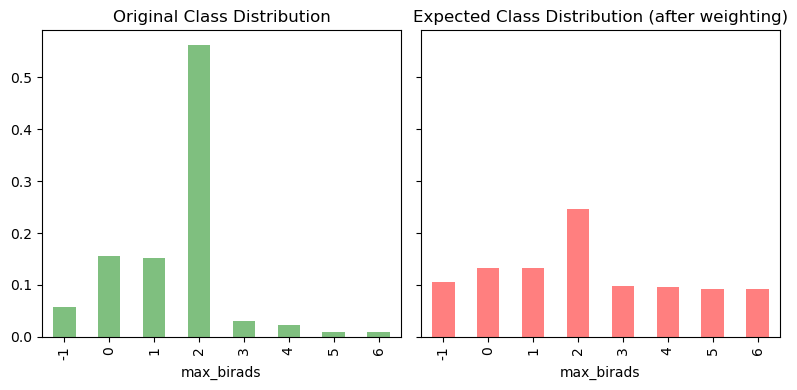

In [52]:
# compute the expected frequency of each class after weighting
expected_freq = class_weights * class_counts
expected_freq /= expected_freq.sum()
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Original Class Distribution
df.max_birads.value_counts(normalize=True).sort_index().plot(
    kind="bar", color="green", alpha=0.5, ax=axes[0]
)
axes[0].set_title("Original Class Distribution")

# Expected Class Distribution
expected_freq.plot(kind="bar", color="red", alpha=0.5, ax=axes[1])
axes[1].set_title("Expected Class Distribution (after weighting)")

plt.tight_layout()
plt.show()

In [53]:
birads2weight = (class_weights/class_weights.median()).to_dict()
birads2weight = {int(k): round(v, 2) for k, v in birads2weight.items()}
print(birads2weight)

{-1: 0.73, 0: 0.34, 1: 0.34, 2: 0.17, 3: 1.27, 4: 1.67, 5: 3.58, 6: 3.76}


In [54]:
df["weight"] = df.apply(
    lambda x: birads2weight[x["max_birads"]] if pd.notna(x["max_birads"]) else birads2weight[-1], axis=1
)

In [55]:
sampler = WeightedRandomSampler(
    weights=df["weight"].values,
    num_samples=len(df),
    replacement=True,
)

In [56]:
sample = list(iter(sampler))  # check that the sampler is working

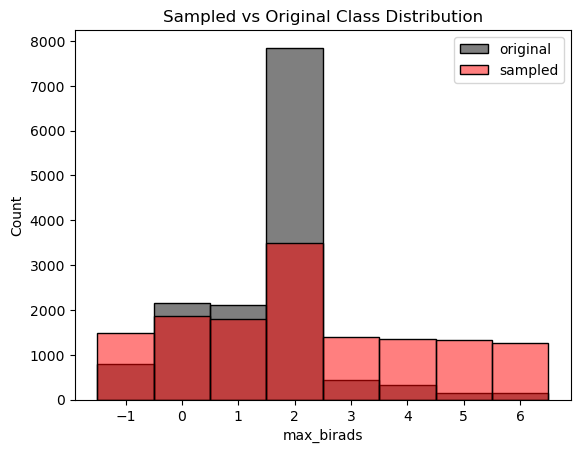

In [57]:
sns.histplot(df.max_birads.astype(int), stat="count", discrete=True, label="original", alpha=0.5, color="black")
sns.histplot(df.max_birads.iloc[sample].astype(int), stat="count", discrete=True, label="sampled", alpha=0.5, color="red")
plt.legend()
plt.title("Sampled vs Original Class Distribution")
plt.show()

In [58]:
complete_df = pd.read_csv("./data/complete-mammo.csv")

In [59]:
df = df.sort_values(by="id").reset_index(drop=True)
complete_df = complete_df.sort_values(by="id").reset_index(drop=True)

In [60]:
len(df), len(complete_df)

(13953, 19874)

In [61]:
# merge the two dataframes using "id" as the key and the column "weight" from df to complete_df
complete_df = complete_df.merge(df[["id", "weight"]], on="id", how="left")